# Redes Neuronales Recurrentes para series de tiempo

Vimos que si vamos agregando más y más información del dataset a nuestras redes neuronales convolucionales, lo hacen mejor. Es decir, podemos pensar en agregar:
- Las últimas $k$ mediciones
- El promedio, la mediana, mínimo y máximo
- EWMA con diferentes alfas
- Desviación estándar
- Algunos percentiles (25%, 75%, etc.)
- Holt-Winters? Algún otro método de predicción?
- etc. etc. etc. etc.

Y sí, en principio no sabemos qué será lo importante para ayudar a la red neuronal a hacer la predicción.

Entonces viene la idea increíble: ¿No sería mejor entrenar una red neuronal para que decidiera qué métricas son las importantes? ¿O incluso que creara sus propias métricas?

Esa es exactamente la idea de las redes neuronales recurrentes!

![Recurrente](https://github.com/mraggi/NeuralSensei2/raw/master/imgs/recurrent.png)

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import fastai.tabular.all as ft
from torch.utils.data import Dataset, DataLoader

In [ ]:
torch.cuda.set_device(1)

In [ ]:
torch.cuda.current_device()

In [2]:
df = pd.read_csv("daily-min-temperatures.csv",index_col='Date',parse_dates=True); df

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
...,...
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5


In [3]:
T=torch.tensor(df['Temp'],dtype=torch.float32)

In [ ]:
T[:10]

In [ ]:
T.shape

In [ ]:
class DatasetSuperBobo(Dataset):
    def __len__(self):
        return 10
    def __getitem__(self,i):
        return i, i*i

In [ ]:
ds = DatasetSuperBobo()

In [ ]:
len(ds)

In [ ]:
ds[7]

In [ ]:
dl = DataLoader(ds,batch_size=3,shuffle=False,drop_last=True)

In [ ]:
for x,y in dl:
    print(f"x = {x}")
    print(f"y = {y}")
    print("-----------------")

In [66]:
import random
random.choice(["K", "Jorge", "Jaz", "JP", "V", "I", "L", "D"])

'V'

In [62]:
class TemperaturaDataset(Dataset):
    def __init__(self, T, max_window = 10):
        self.T = T
        self.max_window = max_window
    
    def __len__(self):
        return len(self.T)
    
    def __getitem__(self, i):
        MW = random.randint(4,16)
        d = i-MW
        first = max(0,d)
        
        
        padding = -torch.zeros((max(0,-d),))
        
        x = torch.cat((padding, self.T[first:i]),dim=0)
        y = self.T[i]
        
        return x, y

In [63]:
class TemperaturaDatasetNP(Dataset):
    def __init__(self, T, max_window = 10):
        self.T = T
        self.max_window = max_window
    
    def __len__(self):
        return len(self.T)-self.max_window
    
    def __getitem__(self, i):
        x = self.T[i:i+self.max_window] 
        y = self.T[i+self.max_window]
        
        return x, y

### Plan manual:

- Crear dataloaders con training y validación
- Crear un modelo que tome como entrada una batch y haga el for loop y escupa todas las y's
- Loop de entrenamiento: loss, backward y optimizar
- Validar

In [81]:
def make_of_size(x,size):
    d = x.shape[0]
    if d > size:
        return x[-size:]
    return torch.cat([torch.zeros(size-d), x])

In [82]:


def my_smart_collate(L):
    y = torch.stack([l[1] for l in L])
    size = random.randint(4,16)
    x = torch.stack([make_of_size(l[0],size) for l in L])
    
    return x,y

In [83]:
mw = 20
train_ds = TemperaturaDataset(T[:-365],max_window=mw)
val_ds = TemperaturaDatasetNP(T[-365-mw:],max_window=mw)

train_dl = DataLoader(train_ds,batch_size=128,shuffle=True,collate_fn=my_smart_collate)
val_dl = DataLoader(val_ds,batch_size=128)

In [84]:
for x,y in train_dl:
    pass

In [85]:
class ModeloRecurrenteManual(nn.Module):
    def __init__(self, hiddenSize = 32):
        super().__init__()
        self.hiddenSize = hiddenSize
        self.model = nn.Sequential(nn.Linear(hiddenSize + 1,64),
                                   nn.ReLU(),
                                   nn.BatchNorm1d(64),
                                   nn.Linear(64,hiddenSize+1))
    def forward(self, x):
        bs, maxWindow = x.shape
        hidden = torch.zeros(bs,self.hiddenSize)
        outputs = []
        for i in range(maxWindow):
            col = x[:,i]
            both = torch.cat([col[:,None],hidden], dim = 1)
            ans = self.model(both)
            output = ans[:,0:1]
            hidden = ans[:,1:]
            outputs.append(output)
        
        return torch.cat(outputs, dim = 1)

In [ ]:
model = ModeloRecurrenteManual()

In [ ]:
from torch.optim import Adam

In [ ]:
num_epochs = 100

In [60]:
def validate():
    model.eval()
    perdidas = [torch.sqrt(F.mse_loss(model(x),y)) for x,y in val_dl]
    return sum(perdidas)/len(perdidas)        

In [ ]:
optimizer = Adam(model.parameters())
for epoch in range(num_epochs):
    model.train()
    for x,y in train_dl:
        #print(x.shape,model(x).shape, y.shape)
        optimizer.zero_grad()
        loss = F.mse_loss(model(x),y)
        loss.backward()
        optimizer.step()
    print(f"{epoch}: {validate()}")

In [61]:
validate()

tensor(2.2388, grad_fn=<DivBackward0>)

# Modelo

In [86]:
class MySimpleRNN(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super().__init__()
        
        self.rnn = nn.GRU(input_size=1,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True)
        
        self.linear = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        y, h_n =  self.rnn(x[:,:,None])
        
        y = y[:,-1,:]
        return self.linear(y).squeeze()

In [87]:
model = MySimpleRNN(128, 2)

In [88]:
x = torch.rand(3,10)

In [89]:
model(x)

tensor([0.0177, 0.0141, 0.0164], grad_fn=<SqueezeBackward0>)

# Manual (con pytorch)

In [90]:
def rmse_error(yp,y):
    w = (yp-y)
    return torch.sqrt((w*w).mean())

In [91]:
from torch import optim
from fastprogress.fastprogress import progress_bar

In [92]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [93]:
epochs = 100

In [94]:
pb = progress_bar(range(epochs))
for epoch in pb:
    for x,y in train_dl:
        optimizer.zero_grad()
        yp = model(x)
        loss = F.mse_loss(yp,y)
        loss.backward()
        optimizer.step()
        pb.comment = f"loss: {loss.item():.3f}"

KeyboardInterrupt: 

##### Ahora hay que validar...

In [35]:
model.eval()
rmse_total = 0
for x,y in val_dl:
    yp = model(x)
    rmse_total += rmse_error(yp,y)

In [36]:
print(f"RMSE: {rmse_total/len(val_dl)}")

RMSE: 2.3902416229248047


# Con fastai

In [48]:
model = MySimpleRNN(64, 2)

In [55]:
dls = ft.DataLoaders.from_dsets(train_ds,val_ds,bs=256)

In [56]:
learn = ft.Learner(dls,model,opt_func=ft.ranger, 
                   loss_func=F.mse_loss,
                   metrics=[F.l1_loss,rmse_error])

SuggestedLRs(valley=0.019054606556892395)

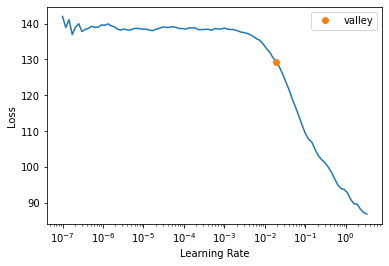

In [51]:
#learn.lr_find()

In [57]:
learn.fit_one_cycle(50,2e-2,div=1,pct_start=0.7)

epoch,train_loss,valid_loss,l1_loss,rmse_error,time
0,49.916756,32.728127,4.685690,5.720623,00:02
1,32.902775,15.651277,3.245742,3.948494,00:01
2,25.545164,12.010742,2.870427,3.457667,00:01
3,20.450474,8.202205,2.290965,2.863947,00:01
4,16.453218,5.792642,1.864565,2.399832,00:02
5,13.717438,5.296576,1.788262,2.287853,00:02
6,11.778878,5.330859,1.813793,2.293797,00:02
7,10.396261,5.263401,1.803846,2.279916,00:02
8,9.362272,5.436500,1.842841,2.317873,00:02
9,8.532975,4.927310,1.726487,2.205516,00:02


KeyboardInterrupt: 